In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ephem 
from simons_array_python.calibration.planet import ephem_planet
from simons_array_python import sa_ephem as sa_ephem
import toast.qarray as qa
from simons_array_python import sa_sql
from toast.tod.sim_focalplane import cartesian_to_quat

INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_data_quality.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_mapping.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_monitor.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_template.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_iq.db attached.


In [2]:
#Load the boresight quaternions in celestial coordinates, along with the times and telescope Az/El timestreams
det_far = '13.11_267.90B'
det_close = '13.13_220.90T'

boresight_quat = np.load('boresight.npy')
times = np.load('bolo_time.npy')
az = np.load('az.npy')
el = np.load('el.npy')

In [3]:
#Convert Az/El to RA/dec using ephem
def azel_to_radecpa(mjd, az, el):
        observer = sa_ephem.pb2a_site()
        ra, dec, pa = [], [], []
        for t, a, e in zip(mjd, az, el):
            observer.date = sa_ephem.mjd_to_ephem_date(t)
            r, d = observer.radec_of(a, e)
            obj = ephem.FixedBody()
            obj._ra, obj._dec = r, d
            obj.compute(observer)
            ra.append(r)
            dec.append(d)
            pa.append(-obj.parallactic_angle())
        return np.array(ra), np.array(dec), np.array(pa)

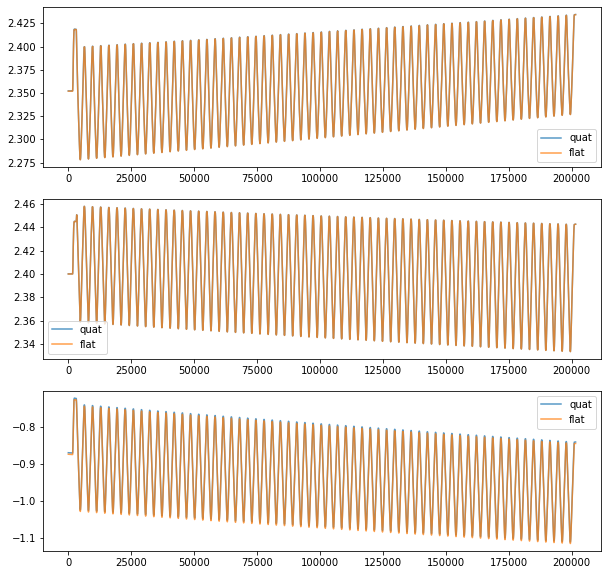

In [4]:
#First make sure the boresight_quats themselves agree with ephem
ra_boresight, dec_boresight, pa_boresight = azel_to_radecpa(times, az , el) 
theta_boresight, phi_boresight, pos_boresight = qa.to_angles(boresight_quat)

fig, axes = plt.subplots(3, figsize=(10,10))

axes[0].plot(phi_boresight, label='quat', alpha=0.75)
axes[0].plot(ra_boresight, label='flat', alpha=0.75)
axes[0].legend()

axes[1].plot(theta_boresight, label='quat', alpha=0.75)
axes[1].plot(np.pi/2 - dec_boresight, label='flat', alpha=0.75)
axes[1].legend()

axes[2].plot(pos_boresight, label='quat', alpha=0.75)
axes[2].plot(pa_boresight, label='flat', alpha=0.75)
axes[2].legend()

#Close enough?

In [5]:
#Load the detector offsets from the database
det_close_offset_x = np.deg2rad(sa_sql.db_impl.focalplane_db[det_close].det_offset_x)
det_close_offset_y = np.deg2rad(sa_sql.db_impl.focalplane_db[det_close].det_offset_y)
print(np.rad2deg(det_close_offset_x), np.rad2deg(det_close_offset_y))

det_far_offset_x = np.deg2rad(sa_sql.db_impl.focalplane_db[det_far].det_offset_x)
det_far_offset_y = np.deg2rad(sa_sql.db_impl.focalplane_db[det_far].det_offset_y)
print(np.rad2deg(det_far_offset_x), np.rad2deg(det_far_offset_y))

#Manually apply the detector offsets in Az/El, then convert to RA/dec
ra_close, dec_close, pa_close = azel_to_radecpa(times, az-(det_close_offset_x/np.median(np.cos(el))) , el-det_close_offset_y) 
ra_far, dec_far, pa_far = azel_to_radecpa(times, az-(det_far_offset_y/np.median(np.cos(el))) , el-det_far_offset_y) 

Reading SQL table pb2a_focalplane...done.
-0.06831 -0.008328
2.004611 -1.56563


In [6]:
#Get the detector pointing from quaternions
det_close_offset_quat = cartesian_to_quat([[np.rad2deg(det_close_offset_x), np.rad2deg(det_close_offset_y), 0]])[0]
det_close_pntg = qa.mult(det_close_offset_quat, boresight_quat)

det_far_offset_quat = cartesian_to_quat([[np.rad2deg(det_far_offset_x), np.rad2deg(det_far_offset_y), 0]])[0]
det_far_pntg = qa.mult(det_far_offset_quat, boresight_quat)

#Decompose detector pntg back into angles for comparison
theta_close, phi_close, pos_close = qa.to_angles(det_close_pntg)
theta_far, phi_far, pos_far = qa.to_angles(det_far_pntg)

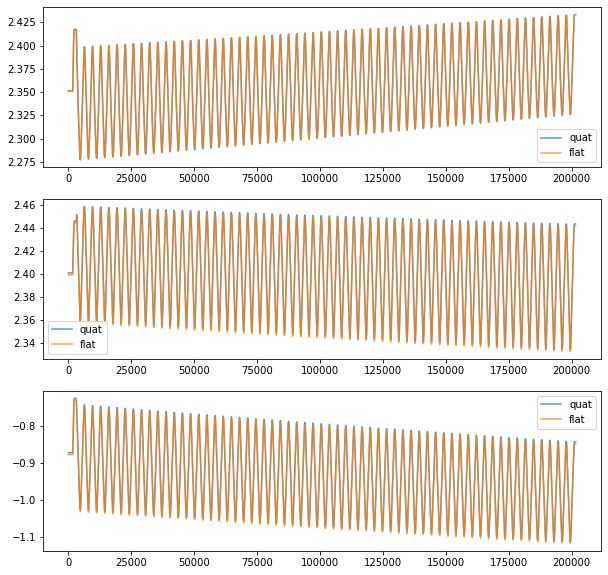

In [7]:
#CLOSE DETECTOR
#Plot phi with RA, dec with theta, etc
fig, axes = plt.subplots(3, figsize=(10,10))

axes[0].plot(phi_close, label='quat', alpha=0.75)
axes[0].plot(ra_close, label='flat', alpha=0.75)
axes[0].legend()

axes[1].plot(theta_close, label='quat', alpha=0.75)
axes[1].plot(np.pi/2 - dec_close, label='flat', alpha=0.75)
axes[1].legend()

axes[2].plot(pos_close, label='quat', alpha=0.75)
axes[2].plot(pa_close, label='flat', alpha=0.75)
axes[2].legend()

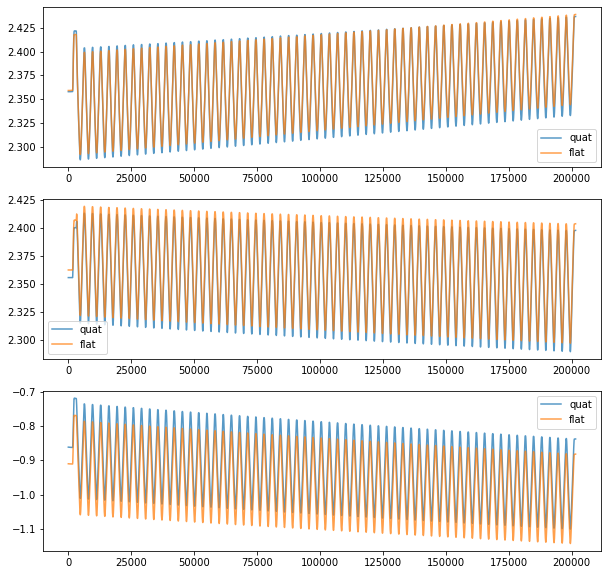

In [8]:
#FAR DETECTOR
#Plot phi with RA, dec with theta, etc
fig, axes = plt.subplots(3, figsize=(10,10))

axes[0].plot(phi_far, label='quat', alpha=0.75)
axes[0].plot(ra_far, label='flat', alpha=0.75)
axes[0].legend()

axes[1].plot(theta_far, label='quat', alpha=0.75)
axes[1].plot(np.pi/2 - dec_far, label='flat', alpha=0.75)
axes[1].legend()

axes[2].plot(pos_far, label='quat', alpha=0.75)
axes[2].plot(pa_far, label='flat', alpha=0.75)
axes[2].legend()

In [9]:
#Errors in degrees:
print(
    'Close detector errors',
    np.rad2deg(np.mean(phi_close) - np.mean(ra_close)),
    np.rad2deg(np.mean(theta_close) - np.mean(np.pi/2 - dec_close)),
    np.rad2deg(np.mean(pos_close) - np.mean(pa_close))
)
print(
    'Far detector errors',
    np.rad2deg(np.mean(phi_far) - np.mean(ra_far)),
    np.rad2deg(np.mean(theta_far) - np.mean(np.pi/2 - dec_far)),
    np.rad2deg(np.mean(pos_far) - np.mean(pa_far))
)

Close detector errors 0.00596042138752117 0.10673156581792313 0.2945225573688117
Far detector errors -0.20520115446821133 -0.369352458851535 2.6415701082687155


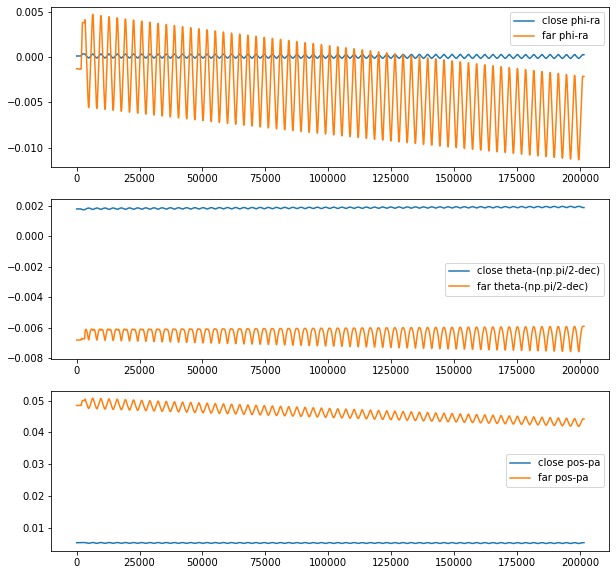

In [10]:
#Difference plots
fig, axes = plt.subplots(3, figsize=(10,10))

axes[0].plot(phi_close-ra_close, label='close phi-ra')
axes[0].plot(phi_far-ra_far, label='far phi-ra')
axes[0].legend()

axes[1].plot(theta_close-(np.pi/2-dec_close), label='close theta-(np.pi/2-dec)')
axes[1].plot(theta_far-(np.pi/2-dec_far), label='far theta-(np.pi/2-dec)')
axes[1].legend()

axes[2].plot(pos_close-pa_close, label='close pos-pa')
axes[2].plot(pos_far-pa_far, label='far pos-pa')
axes[2].legend()